# Wildfire Data Analysis and Prediction

## Library and Data Imports

In [ ]:
!pip install pandasql
!pip install -U plotly
!pip install geopandas

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandasql as ps
from sklearn import tree, preprocessing
from sklearn.linear_model import Ridge
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split
import sqlite3
import datetime as dt
import itertools
import requests
import plotly.express as px
import urllib
from lxml import html
from tqdm import tqdm

import seaborn as sns
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette("flare")
palette = itertools.cycle(sns.color_palette())
c1 = next(palette)
c2 = next(palette)
c3 = next(palette)
c4 = next(palette)
c5 = next(palette)
c6 = next(palette)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Connect to sqlite database and pull in relevent columns

In [ ]:
conn = sqlite3.connect("drive/Shareddrives/CIS545FinalProject/FPA_FOD_20170508.sqlite")
df_fires = pd.read_sql_query("SELECT FOD_ID, FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,CONT_TIME,DISCOVERY_TIME FROM 'Fires'", conn)

Let's take a glance at our data

In [ ]:
df_fires.head()

,FOD_ID,FIRE_CODE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,CONT_TIME,DISCOVERY_TIME
0,1,BJ8K,FOUNTAIN,2005,2453403.5,9.0,Miscellaneous,2453403.5,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,1730,1300
1,2,AAC0,PIGEON,2004,2453137.5,1.0,Lightning,2453137.5,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,1530,0845
2,3,A32W,SLACK,2004,2453156.5,5.0,Debris Burning,2453156.5,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,2024,1921
3,4,None,DEER,2004,2453184.5,1.0,Lightning,2453189.5,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,1400,1600
4,5,None,STEVENOT,2004,2453184.5,1.0,Lightning,2453189.5,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,1200,1600


## Exploratory Data Analysis

We need to change our date format to make it more readable

In [ ]:
df_fires['DISCOVERED_DATE'] = pd.to_datetime(df_fires['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df_fires['CONTAINED_DATE'] = pd.to_datetime(df_fires['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

df_fires['DISCOVERED_MONTH'] = df_fires['DISCOVERED_DATE'].dt.month
df_fires['DISCOVERED_DAY'] = df_fires['DISCOVERED_DATE'].apply(lambda x: x.timetuple().tm_yday)


### Fires over Time

Annual

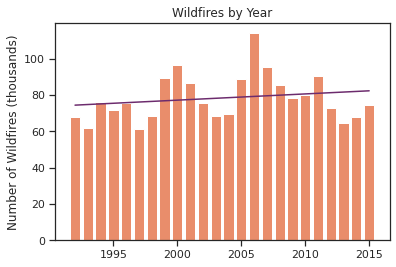

In [ ]:
# df_fires_year = ps.sqldf("SELECT FIRE_YEAR, COUNT(FOD_ID) as COUNT FROM df_fires GROUP BY FIRE_YEAR DESC")
# very slow to use pandas sql^, going to just use pandas for now

df_fires_year = df_fires[['FOD_ID', 'FIRE_YEAR']].groupby(by='FIRE_YEAR').count()
df_fires_year['FOD_ID'] = df_fires_year['FOD_ID']/1000

sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
plt.bar(x = df_fires_year.index, height = df_fires_year['FOD_ID'])
plt.ylabel('Number of Wildfires (thousands)')
plt.title('Wildfires by Year')

# fit a trendline to the data
lr = Ridge()
lr.fit(df_fires_year.reset_index()[['FIRE_YEAR']], df_fires_year['FOD_ID'])
plt.plot(df_fires_year.index, lr.coef_*df_fires_year.index+lr.intercept_, color=c6)
plt.show()

Monthly

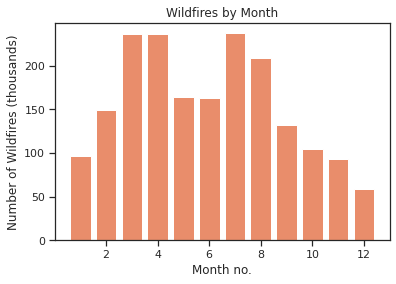

In [ ]:
df_fires['DISCOVERED_DATE'] = pd.to_datetime(df_fires['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df_fires['CONTAINED_DATE'] = pd.to_datetime(df_fires['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

# df_fires['DISCOVERED_MONTH'] = df_fires['DISCOVERED_DATE'].dt.month

df_fires_month = df_fires[['FOD_ID', 'DISCOVERED_MONTH']].groupby(by='DISCOVERED_MONTH').count()

sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
plt.bar(x = df_fires_month.index, height = df_fires_month['FOD_ID']/1000)
plt.ylabel('Number of Wildfires (thousands)')
plt.xlabel('Month no.')
plt.title('Wildfires by Month')
plt.show()

Day of year

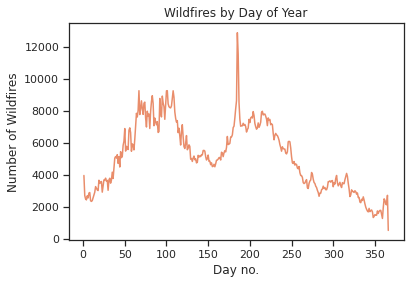

In [ ]:
df_fires_day = df_fires[['FOD_ID', 'DISCOVERED_DAY']].groupby(by='DISCOVERED_DAY').count()

sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
sns.lineplot(x = df_fires_day.index, y = df_fires_day['FOD_ID'])
plt.ylabel('Number of Wildfires')
plt.xlabel('Day no.')
plt.title('Wildfires by Day of Year')
plt.show()

In [ ]:
df_fires_day.rename(columns={'FOD_ID' : 'COUNT'}).sort_values(by='COUNT', ascending=False).head()

,COUNT
DISCOVERED_DAY,
185,12875
186,11535
101,9261
67,9260
108,9256


We can see that a spike in fires happens on the Fourth of July

### Fires by State
Which states have had the highest count of fires during 1992-2015?

In [ ]:
df_fires_states = df_fires[['FOD_ID', 'STATE']].groupby(by="STATE").count()

fig = px.choropleth(df_fires_states.reset_index(), locationmode = "USA-states", locations='STATE', color='FOD_ID',
                           color_continuous_scale="Viridis",
                           range_color=(0, 190000),
                           scope="usa",
                           labels={'FOD_ID':'Number of Wildfires'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
df_fires_states.rename(columns={'FOD_ID' : 'COUNT'}).sort_values(by='COUNT', ascending=False).head()

,COUNT
STATE,
CA,189550
GA,168867
TX,142021
NC,111277
FL,90261


The top three are California, Georgia and Texas

### Fires by Cause

What were the leading causes of fires across the US and in California during 1992-2015?

Let's flip over and use our sql skills to build out the rest of this EDA

In [ ]:
causes_query = '''
select df_fires.STAT_CAUSE_DESCR as CAUSE, count(df_fires.FOD_ID)/1000 COUNT
    from df_fires
    group by df_fires.STAT_CAUSE_DESCR
    order by COUNT desc
'''

In [ ]:
causes_query_CA = '''
select df_fires.STAT_CAUSE_DESCR as CAUSE, count(df_fires.FOD_ID)/1000 COUNT_CA
    from df_fires
    where STATE like 'CA'
    group by df_fires.STAT_CAUSE_DESCR
    order by COUNT_CA desc
'''

In [ ]:
df_causes = ps.sqldf(causes_query, locals())

In [ ]:
df_causes_CA = ps.sqldf(causes_query_CA, locals())

In [ ]:
#creating a pct column to compare both, merging both dframes into 1 for plotting purposes
df_causes['PCT'] = 100*df_causes['COUNT']/sum(df_causes['COUNT'])
df_causes_CA['PCT_CA'] = 100*df_causes_CA['COUNT_CA']/sum(df_causes_CA['COUNT_CA'])
df_causes_both = df_causes.merge(df_causes_CA,how='inner', on='CAUSE')

In [ ]:
df_causes_both_index = df_causes_both.set_index('CAUSE')

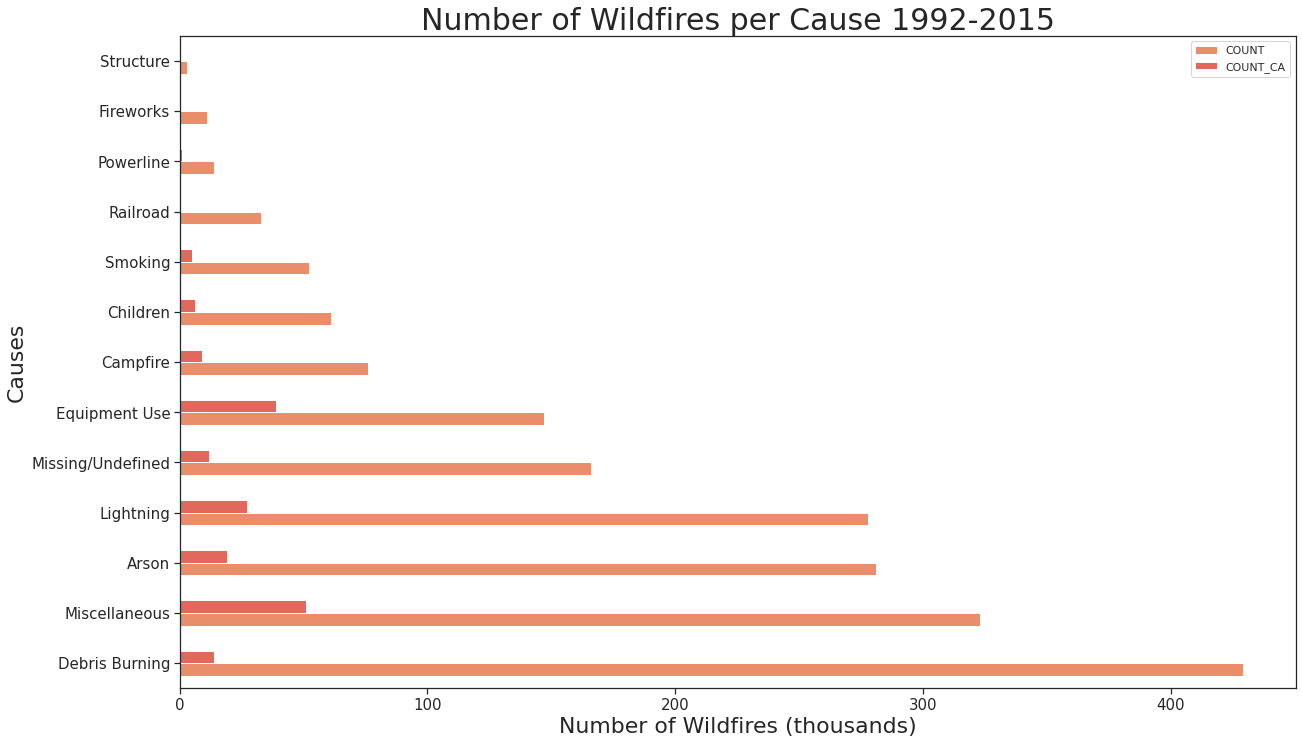

In [ ]:
#plot total number of fires 
ax = df_causes_both_index[['COUNT','COUNT_CA']].plot.barh(figsize=(20,12),label = ['USA','CA'])
plt.ylabel('Causes', size = 22)
plt.xlabel('Number of Wildfires (thousands)', size = 22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Number of Wildfires per Cause 1992-2015', size = 30)
# plt.xticks(np.arange(0, max(COUNT), 2))
plt.legend()
plt.show()

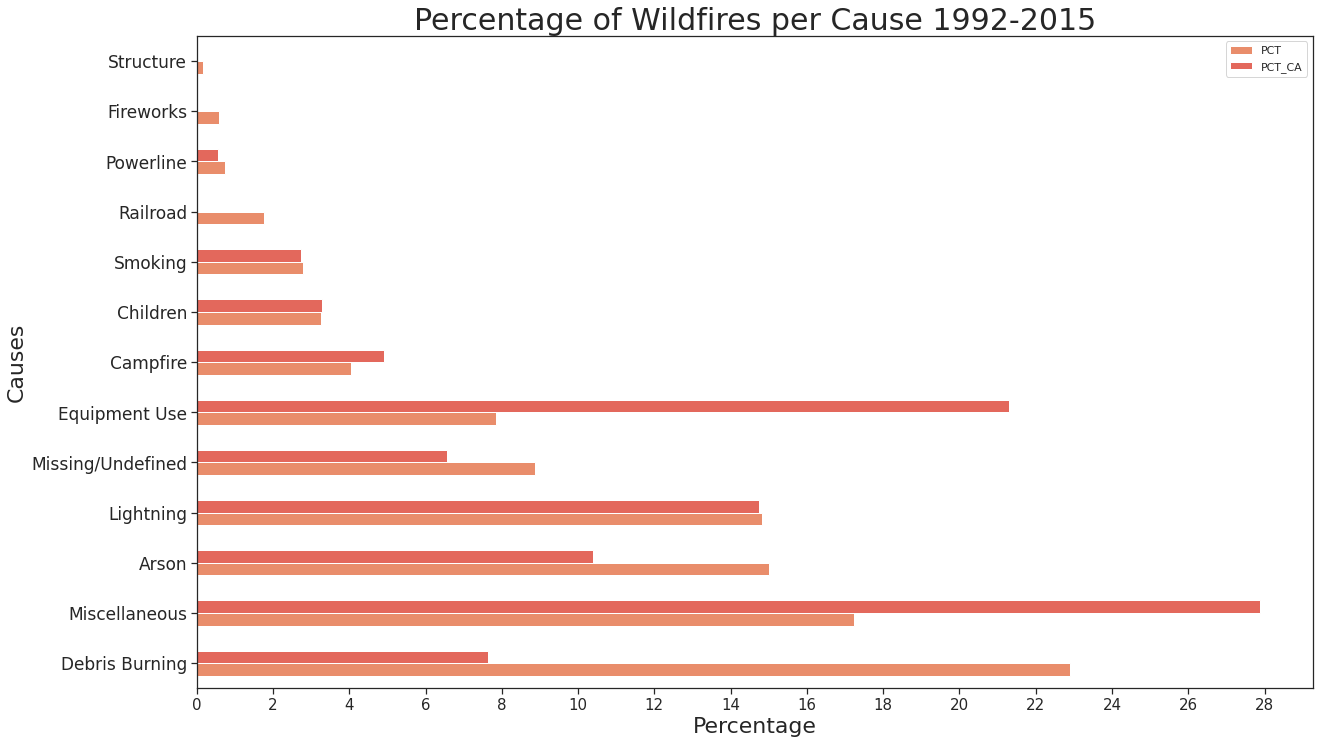

In [ ]:
#plotting percentage of causes
ax = df_causes_both_index[['PCT','PCT_CA']].plot.barh(figsize=(20,12),label = ['USA','CA'])
plt.ylabel('Causes', size = 22)
plt.xlabel('Percentage', size = 22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=17)
plt.title('Percentage of Wildfires per Cause 1992-2015', size = 30)
plt.xticks(np.arange(0, 30, 2))
plt.legend()
plt.show()

Were the leading causes different during 2010-2015?

In [ ]:
causes_query_2010 = '''
select df_fires.STAT_CAUSE_DESCR as CAUSE, count(df_fires.FOD_ID)/1000 COUNT
    from df_fires
    where FIRE_YEAR > 2010
    group by df_fires.STAT_CAUSE_DESCR
    order by COUNT desc
'''

In [ ]:
causes_query_2010_CA = '''
select df_fires.STAT_CAUSE_DESCR as CAUSE, count(df_fires.FOD_ID)/1000 COUNT_CA
    from df_fires
    where FIRE_YEAR > 2010 AND STATE like 'CA'
    group by df_fires.STAT_CAUSE_DESCR
    order by COUNT_CA desc
'''

In [ ]:
df_causes_after_2010 = ps.sqldf(causes_query_2010, locals())


In [ ]:
df_causes_CA_after_2010 = ps.sqldf(causes_query_2010_CA, locals())


In [ ]:
#merging both dframes
df_causes_after_2010['PCT'] = 100*df_causes_after_2010['COUNT']/sum(df_causes_after_2010['COUNT'])
df_causes_CA_after_2010['PCT_CA'] = 100*df_causes_CA_after_2010['COUNT_CA']/sum(df_causes_CA_after_2010['COUNT_CA'])
df_causes_both_after_2010 = df_causes_after_2010.merge(df_causes_CA_after_2010,how='inner', on='CAUSE')
df_causes_both_after_2010_index = df_causes_both.set_index('CAUSE')

In [ ]:
df_causes_both_after_2010_index

In [ ]:
#plot total number of fires 
ax = df_causes_both_after_2010_index[['COUNT','COUNT_CA']].plot.barh(figsize=(20,12),label = ['USA','CA'])
plt.ylabel('Causes', size = 22)
plt.xlabel('Number of Wildfires (thousands)', size = 22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=17)
plt.title('Number of Wildfires per Cause 2010-2015', size = 30)
# plt.xticks(np.arange(0, max(COUNT), 2))
plt.legend()
plt.show()

In [ ]:
#plotting percentage of causes
ax = df_causes_both_after_2010_index[['PCT','PCT_CA']].plot.barh(figsize=(20,12),label = ['USA','CA'])
plt.ylabel('Causes', size = 22)
plt.xlabel('Percentage', size = 22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=17)
plt.title('Percentage of Wildfires per Cause 2010-2015', size = 30)
plt.xticks(np.arange(0, 30, 2))
plt.legend()
plt.show()

In [ ]:
df_fires.head()

What was the average size of fires per cause?

In [ ]:
#average size per cause
causes_size_query = '''
select df_fires.STAT_CAUSE_DESCR as CAUSE, avg(df_fires.FIRE_SIZE) AVERAGE_SIZE
    from df_fires
    group by df_fires.STAT_CAUSE_DESCR
    order by AVERAGE_SIZE desc
'''

In [ ]:
df_causes_size = ps.sqldf(causes_size_query, locals())

In [ ]:
df_causes_size.head()

In [ ]:
#average size per cause
causes_size_query_CA = '''
select df_fires.STAT_CAUSE_DESCR as CAUSE, avg(df_fires.FIRE_SIZE) AVERAGE_SIZE_CA
    from df_fires
    where STATE like 'CA'
    group by df_fires.STAT_CAUSE_DESCR
    order by AVERAGE_SIZE_CA desc
'''

In [ ]:
df_causes_size_CA = ps.sqldf(causes_size_query_CA, locals())

In [ ]:
#merging both dframes
df_causes_both_size = df_causes_size.merge(df_causes_size_CA,how='inner', on='CAUSE')
df_causes_both_index = df_causes_both_size.set_index('CAUSE')


In [ ]:
df_causes_both_index.head()

In [ ]:
#plotting percentage of causes
ax = df_causes_both_index[['AVERAGE_SIZE','AVERAGE_SIZE_CA']].plot.barh(figsize=(20,12),label = ['USA','CA'])
plt.ylabel('Causes', size = 22)
plt.xlabel('Average Size (acres)', size = 22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=17)
plt.title('Average Size of Wildfires per Cause 1992-2015', size = 30)
plt.xticks(np.arange(0, 700, 25))
plt.legend()
plt.show()

### Fires by Length



In which states do the fires burn the longest? For how long?

In [ ]:
#find the length of fire
time_dif_query = '''
select FOD_ID, STATE,FIRE_YEAR, (1440*ABS(strftime('%d',CONTAINED_DATE)-strftime('%d',DISCOVERED_DATE))+(CONT_TIME-DISCOVERY_TIME)) as MIN_DIF
    from df_fires
'''

In [ ]:
df_time_dif = ps.sqldf(time_dif_query, locals())

In [ ]:
df_time_dif = df_time_dif.dropna()

In [ ]:
avg_len_state_query = '''

select STATE, avg(MIN_DIF) as AVG_MIN_DIF, avg(MIN_DIF)/60 as AVG_H_DIF
    from df_time_dif
    group by STATE
    order by AVG_MIN_DIF desc
'''


In [ ]:
df_avg_len_state = ps.sqldf(avg_len_state_query, locals())

In [ ]:
df_avg_len_state.head()

In [ ]:
#map plotting
fig = px.choropleth(df_avg_len_state, locationmode = "USA-states", locations='STATE', color='AVG_H_DIF',
                           color_continuous_scale="Viridis",
                           range_color=(0, 145),
                           scope="usa",
                           labels={'AVG_H_DIF':'Average Length of Wildfires (hours)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
df_time_dif.head()

In [ ]:
date_dif_query = '''

select STATE, avg(ABS(strftime('%d',CONTAINED_DATE)-strftime('%d',DISCOVERED_DATE))) as AVG_DATE_DIF
    from df_fires
    group by STATE
    order by AVG_DATE_DIF desc
'''


### Fires by size

In which states are the fires most destructive? How big are they on average?

In [ ]:
avg_size_state_query = '''

select STATE, avg(FIRE_SIZE) as AVG_SIZE
    from df_fires
    group by STATE
    order by AVG_SIZE desc
'''

In [ ]:
df_avg_size_state = ps.sqldf(avg_size_state_query, locals())

In [ ]:
df_avg_size_state.head()

In [ ]:
#map plotting
fig = px.choropleth(df_avg_size_state, locationmode = "USA-states", locations='STATE', color='AVG_SIZE',
                           color_continuous_scale="Viridis",
                           range_color=(0, 500),
                           scope="usa",
                           labels={'AVG_SIZE':'Average Size of Wildfires (acres)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Predictive Models

Next, let's just take a subset of our data to make our modeling process faster. We can use the whole dataset later to ensure we are building a robust model.

In [ ]:
df_fires = df_fires.sample(frac=0.3, random_state=42)

### Predicting Wildfire Causes

Preprocess data

In [ ]:
# classification problem 

# drop null values and columns which don't have relevence to the question
df_fires_subset = df_fires[['FOD_ID', 'FIRE_YEAR', 'DISCOVERED_MONTH', 'DISCOVERED_DAY', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'STAT_CAUSE_DESCR']].dropna().set_index('FOD_ID')
# also drop all rows where cause is missing
df_fires_subset = df_fires_subset[df_fires_subset['STAT_CAUSE_DESCR'] != 'Missing/Undefined']

df_fires_clean = pd.get_dummies(df_fires_subset, columns=['DISCOVERED_MONTH', 'DISCOVERED_DAY'])

X = df_fires_clean.drop(columns=['STAT_CAUSE_DESCR'])
y = df_fires_clean['STAT_CAUSE_DESCR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("X_train shape")
print(X_train.shape)
print("X_test shape")
print(X_test.shape)
print("y_train shape")
print(y_train.shape)
print("y_test shape")
print(y_test.shape)

**Model 1: Benchmark**

We can establish a baseline to make sure that our fancy models are actually doing something useful

The simplest benchmark to use will just be to guess the most common cause - debris burning.

In [ ]:
y_pred = pd.Series(['Debris Burning']).repeat(len(y_test))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

As long as we can beat an accuracy of 25% we will have built a useful model.

**Model 2: Decision Tree**

Let's use our Fire Size feature to build a simple decision tree model and see if it improves our accuracy

In [ ]:
X_train_tree = X_train[['FIRE_SIZE']]
X_test_tree = X_test[['FIRE_SIZE']]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train_tree, y_train)

y_pred = clf.predict(X_test_tree)

In [ ]:
accuracy_score(y_test, y_pred)

It seems that by just using the size of a fire, we can improve our prediction by just a bit. However, our score still isn't very good.

We can look at a confusion matrix to see what predictions our model is making. A perfect model would have a rating of 1.0 on a downward-sloping diagonal line and 0.0 everywhere else.

In [ ]:
from sklearn.metrics import plot_confusion_matrix
ax = plot_confusion_matrix(clf, X_test_tree, y_test, normalize='true', xticks_rotation='vertical', include_values=False)
plt.title("Confusion Matrix")

**Model 3: Add more features**

Let's add in the rest of our seemingly relevent features into our tree model to see how it improves our prediction accuracy.

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

**This** is a great improvement on our previous models! Let's take a look at our new confusion matrix.

In [ ]:
ax = plot_confusion_matrix(clf, X_test, y_test, normalize='true', xticks_rotation='vertical', include_values=False)
plt.title("Confusion Matrix")

We can see a diagonal line developing! And we are no longer simply predicting debris or lightning for every case. In particular, we are very accurately predicting lightning strikes.

**Model 5: Random Forest**

Let's now see if using a fancier method can yield a better accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(random_state=42, verbose=2)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [ ]:
accuracy_score(y_pred, y_test)

In [ ]:
ax = plot_confusion_matrix(clf, X_test, y_test, normalize='true', xticks_rotation='vertical', include_values=False)
plt.title("Confusion Matrix")

### Predicting Time to Extinguish After Detection, run Fires by Length

**Preprocess data**

In [ ]:
df_fires.head()

In [ ]:
df_id_len = df_time_dif[['FOD_ID','MIN_DIF']]
df_fires_len = pd.merge(df_fires, df_id_len, on="FOD_ID")
df_fires_len_clean = df_fires_len.drop(['FIPS_NAME','CONT_TIME','DISCOVERY_TIME','DISCOVERED_DATE','CONTAINED_DATE','OWNER_DESCR','FIRE_SIZE_CLASS','CONT_DATE','STAT_CAUSE_DESCR','DISCOVERY_DATE','FIRE_NAME','FIRE_CODE','STATE','COUNTY','FIPS_CODE'],axis = 1).dropna().set_index('FOD_ID')


In [ ]:
#is the data correlated?
corr_matrix = df_fires_len_clean.corr()

import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
#one hot encode the months, days, owner code, cause code
df_fires_len_clean_one_hot = pd.get_dummies(df_fires_len_clean, columns=['DISCOVERED_MONTH', 'DISCOVERED_DAY', 'OWNER_CODE','STAT_CAUSE_CODE'])


In [ ]:
#split into X and y
label = df_fires_len_clean_one_hot[['MIN_DIF']]
features = df_fires_len_clean_one_hot.drop(columns=['MIN_DIF'])

**Split into train and test data**

In [ ]:
from sklearn.model_selection import train_test_split
# Split into train and testing data

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2)

**Model 1: Linear Regression Normal**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

model_LR = LinearRegression().fit(x_train,y_train)
y_pred_LR = model_LR.predict(x_test)


print("LR Score:", model_LR.score(x_test, y_test))

# Different error measures
print("LR MAE:", mean_absolute_error(y_test, y_pred_LR))
print('LR MSE:', mean_squared_error(y_test, y_pred_LR))
print('LR RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_LR)))



**Model 2: Lasso**

In [ ]:
#using Lasso/L1 regularization
from sklearn.linear_model import Lasso
# from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

clf_L1 = Lasso()
clf_L1.fit(x_train, y_train)

y_pred_L1 = clf_L1.predict(x_test)


print("L1 Score:", clf_L1.score(x_test, y_test))

# Different error measures
print("L1 MAE:", mean_absolute_error(y_test, y_pred_L1))
print('L1 MSE:', mean_squared_error(y_test, y_pred_L1))
print('L1 RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_L1)))


**Model 2: Elastic Net**

In [ ]:
#using Elastic Net regularization
from sklearn.linear_model import ElasticNet

clf_EN = ElasticNet()
clf_EN.fit(x_train, y_train)

y_pred_EN = clf_EN.predict(x_test)

print("EN Score:", clf_EN.score(x_test, y_test))

# Different error measures
print("EN MAE:", mean_absolute_error(y_test, y_pred_EN))
print('EN MSE:', mean_squared_error(y_test, y_pred_EN))
print('EN RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_EN)))

# print(clf_EN.coef_)

In [ ]:

# from sklearn.model_selection import GridSearchCV
# # Your code goes here
# # Only tune the max depth of the trees in the RF hyperparameter.

# depth = [12,18]
# nEstimator = [140]

# hyperparameters = {'max_depth':depth,'n_estimators':nEstimator}

# GS_object = GridSearchCV(RandomForestRegressor(),param_grid=hyperparameters,scoring='neg_mean_squared_error')

# GS_object.fit(x_train,y_train)

In [ ]:
# best_hyperparameters = {'max_depth':GS_object.best_params_.get('max_depth'),'n_estimators':nEstimator}
# best_max_depth = GS_object.best_params_.get('max_depth')

**Model 4: Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RF_object = RandomForestRegressor(max_depth=7)
fit_pred = RF_object.fit(x_train,y_train)
y_pred_RF = fit_pred.predict(x_test)

print("RF Score:", RF_object.score(x_test, y_test))
print("RF MAE:", mean_absolute_error(y_test, y_pred_RF))
print('RF MSE:', mean_squared_error(y_test, y_pred_RF))
print('RF RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_RF)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KeyboardInterrupt: ignored